In [1]:
import os
import time
import pandas as pd
import numpy as np
from random import sample
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from Bio import SeqIO
from multiprocessing import Process

import matplotlib.pyplot as plt

# device

In [2]:
dev = 'cuda'
dev2 = 'cuda'

In [ ]:
# Get the maximum GPU memory usage by tensors
print("Max allocated GPU memory: ", torch.cuda.max_memory_allocated() / (1024 ** 2), " MB")

# data prep with class

In [3]:
clade_info = pd.read_csv('/data/docker_qiime2_share_G/jingjie/all_ec2/CNN/CNN_trans/clade_info_2.csv',
                         index_col = 0,
                         header = None)

clade = {}

for x in set(clade_info.iloc[:, 0]):
    clade[x] = []

for x in list(clade_info.index):
    clade[clade_info.loc[x, 1]].append(x)
    
train_set = []
test_set = []

total_each = 180
for_train = 160

for x in clade.keys():
    to = sample(clade[x], total_each)# 每个类取 个
    train_set.extend(to[0: for_train])# 给训练集 个
    test_set.extend(to[for_train: ])# 给测试集 个
    
print(len(train_set))
print(len(test_set))

960
120


In [4]:
softmax = {'A': [1,0,0,0,0,0], 
           'B1': [0,1,0,0,0,0], 
           'B2': [0,0,1,0,0,0],
           'D': [0,0,0,1,0,0],
           'E': [0,0,0,0,1,0],
           'N9': [0,0,0,0,0,1],}

In [5]:
class genome_Dataset(Dataset):
    def __init__(self,
                 set_to_read,
                 ours_dir = '/data/docker_qiime2_share_G/Hejunwei/core_genome_study/CNN/np/',
                 GCA_dir = '/data/docker_qiime2_share_G/Hejunwei/core_genome_study/CNN/np/',
                 clade_info = '/data/docker_qiime2_share_G/jingjie/all_ec2/CNN/CNN_trans/clade_info_2.csv',
                 lab_converter = softmax,
                 des = dev):
        
        self.clade_info = pd.read_csv(clade_info,
                                      index_col = 0,
                                      header = None)
        
        self.indx = list(self.clade_info.index)
        
        self.to_read_indx = [self.indx.index(x) for x in set_to_read]
        
        self.go_tab = self.clade_info.iloc[self.to_read_indx, :]
        
        self.des = des
        
        self.lab_converter = lab_converter
        
        self.GCA_dir = GCA_dir
        self.ours_dir = ours_dir
        
    def __len__(self):
        return len(self.go_tab.index)
        
    def __getitem__(self, idx):
        ind_lst = list(self.go_tab.index)
        
        if 'GCA' in ind_lst[idx]:
            path = self.GCA_dir
        else:
            path = self.ours_dir
            
        ft = torch.from_numpy(np.load(path 
                                      + ind_lst[idx] 
                                      + '.npy')
                                      ).type(torch.FloatTensor).to(device = self.des)
        
        ft = ft.reshape(1, 4, 721826)
        
        lab = torch.FloatTensor(self.lab_converter[self.go_tab.iloc[idx, 0]
                                                  ]
                               ).to(device = self.des)
        lab = lab.reshape(6)
        
        return ft, lab

In [6]:
training_data = genome_Dataset(set_to_read = train_set)
testing_data = genome_Dataset(set_to_read = test_set)

In [7]:
# train_dataloader = DataLoader(training_data, batch_size = len(train_set), shuffle = False, num_workers = 0)
# test_dataloader = DataLoader(testing_data, batch_size = len(test_set), shuffle = False, num_workers = 0)

train_dataloader = DataLoader(training_data, batch_size = 60, shuffle = False, num_workers = 0, drop_last = False, pin_memory = False)
test_dataloader = DataLoader(testing_data, batch_size = 60, shuffle = False, num_workers = 0, drop_last = False, pin_memory = False)

# model 

In [8]:
# ```Python
class the_model(nn.Module):

    def __init__(self):
        super(the_model, self).__init__()
        
#         self.dropout = nn.Dropout(p = 0.2)
        
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 6,
                               kernel_size = (4, 33),
                               stride = 1
                              ).to(torch.device(dev))
        
        self.mp1 = nn.MaxPool2d(kernel_size = (1, 31), 
                                stride = 5
                               ).to(torch.device(dev)
                                   )
        
        
        self.conv2 = nn.Conv2d(in_channels = 6,
                               out_channels = 1,
                               kernel_size = (1, 6),
#                                stride = 1
                              ).to(torch.device(dev))
        
        self.mp2 = nn.MaxPool2d(kernel_size = (1, 10),
                    stride = 2).to(torch.device(dev))
        
        
        self.conv3 = nn.Conv2d(in_channels = 1,
                               out_channels = 1,
                               kernel_size = (1, 3),
#                                stride = 1
                              ).to(torch.device(dev)
                                  )
                                   
        self.mp3 = nn.MaxPool2d(kernel_size = (1, 20),
                                stride = 5).to(torch.device(dev)
                                              )
                                   
        self.conv4 = nn.Conv2d(in_channels = 1,
                               out_channels = 1,
                               kernel_size = (1, 3),
#                                stride = 1
                              ).to(torch.device(dev)
                                  )
        self.mp4 = nn.MaxPool2d(kernel_size = (1, 30),
                                stride = 10).to(torch.device(dev)
                                               )
        
        self.fc1 = nn.Linear(1440, 
                             6
                            ).to(torch.device(dev)
                                )
        
#         self.fc2 = nn.Linear(in_features = 1000, 
#                              out_features = 6
#                             ).to(torch.device(dev)
#                                 )
        
    def forward(self, x):
        
        x = self.conv1(x)
#         x = self.dropout(x)
        x = self.mp1(x)
        
        x = self.conv2(x)
#         x = self.dropout(x)
        x = self.mp2(x)
        
        x = self.conv3(x)
#         x = self.dropout(x)
        x = self.mp3(x)
                                   
        x = self.conv4(x)
#         x = self.dropout(x)
        x = self.mp4(x)
        
        x = torch.flatten(x, 1)
#         x = self.dropout(x)
        
        x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         x = self.fc4(x)
        
#         x = self.bo(x)
        
        return x
# ```

# train

In [9]:
net = the_model()

In [10]:
loss_function = nn.CrossEntropyLoss().to(torch.device(dev))
# loss_function = nn.MSELoss().to(torch.device(dev))
# loss_function = nn.BCELoss().to(torch.device(dev))
optimizer = torch.optim.Adam(net.parameters(), 
                             lr = 1e-3,
                             weight_decay = 0
                            )

In [11]:
m1 = nn.Sigmoid()
m2 = nn.Softmax(dim = 1)

0
Mon Nov 14 12:27:37 2022
train loss: 4.179014075547457
test loss: 1.8169073462486267
predict right count in train: tensor(100., device='cuda:0')
predict right count in test: tensor(20., device='cuda:0')


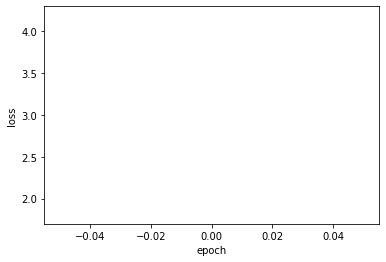

1
Mon Nov 14 12:29:17 2022
train loss: 1.9863807708024979
test loss: 2.3149646520614624
predict right count in train: tensor(40., device='cuda:0')
predict right count in test: tensor(20., device='cuda:0')


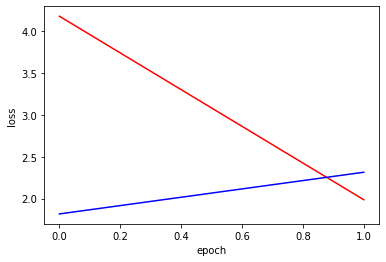

2
Mon Nov 14 12:30:53 2022
train loss: 2.1389134600758553
test loss: 1.9106868505477905
predict right count in train: tensor(147., device='cuda:0')
predict right count in test: tensor(20., device='cuda:0')


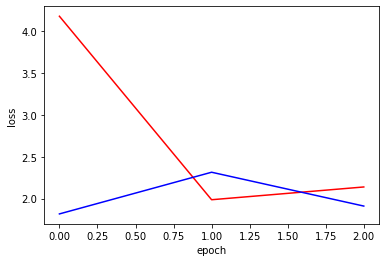

3
Mon Nov 14 12:32:29 2022


KeyboardInterrupt: 

In [12]:
if __name__ == '__main__':

    losses = []
    losses_test = []
    
    for epoch in range(1000):

        print(epoch)
        print(time.asctime())
        
        net.eval()
        with torch.no_grad():

            record_of_test_loss = 0.0
            test_right_pred_ = 0.0
            
            count = 0
            
            for data_test in test_dataloader:
                i_test, l_test = data_test

                pred_y_test = net(i_test)

                loss_test = loss_function(pred_y_test, l_test)

                record_of_test_loss = record_of_test_loss + loss_test.item()
    
                test_right_pred = (m2(m1(pred_y_test
                                        )
                                     ).argmax(1) == l_test.argmax(1)).sum()
        
                test_right_pred_ = test_right_pred_ + test_right_pred
            
                count += 1

            losses_test.append(record_of_test_loss/count)
        
        net.train()
        record_of_train_loss = 0.0
        train_right_pred_ = 0.0
        
        count = 0
        
        for data in train_dataloader:
            i, l = data

            pred_y = net(i)

            loss = loss_function(pred_y, l)
            
            record_of_train_loss = record_of_train_loss + loss.item()
        
            train_right_pred = (m2(m1(pred_y
                                        )
                                     ).argmax(1) == l.argmax(1)).sum()
        
            train_right_pred_ = train_right_pred_ + train_right_pred
    
            count += 1
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        losses.append(record_of_train_loss/count)
        

        
        plt.plot(losses, 'r')
        plt.plot(losses_test, 'b')
        plt.ylabel('loss')
        plt.xlabel('epoch')
    #     plt.title('Train')
    
    
        print('train loss: ' + str(losses[-1]))
        print('test loss: ' + str(losses_test[-1]))
        print('predict right count in train: ' + str(train_right_pred_))
        print('predict right count in test: ' + str(test_right_pred_))
        
        plt.show()

        torch.save(net.state_dict(), 
                   '/data/docker_qiime2_share_G/Hejunwei/core_genome_study/CNN/dataloader_models/' 
                   + str(epoch)
                   +'_epoch_.pth')